In [1]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from typing import List
from transform import TimeSeriesTransform
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [3]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [4]:
load = '20kg'
filenames_20kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_20kg = [filename for sublist in filenames_20kg for filename in sublist]

load = '40kg'
filenames_40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_40kg = [filename for sublist in filenames_40kg for filename in sublist]

load = '-40kg'
filenames_m40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_m40kg = [filename for sublist in filenames_m40kg for filename in sublist]

In [5]:
def get_X_y(filenames, load, is_train=True):
    X, y = [], []
    data_dir = INSTANCES_DIR if is_train else INFERENCE_DIR
    for filename in filenames:
        load_num = load[:-2]
        state = re.match(fr'(.*)_{load_num}', filename).group(1)
        df = pd.read_csv(os.path.join(data_dir, load, state, filename))
        tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
        # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
        X.append(tmp_cur)
        y.append(state)
    return np.array(X), np.array(y)

In [6]:
X_20kg, y_20kg = get_X_y(filenames_20kg, load='20kg')
X_40kg, y_40kg = get_X_y(filenames_40kg, load='40kg')
X_m40kg, y_m40kg = get_X_y(filenames_m40kg, load='-40kg')

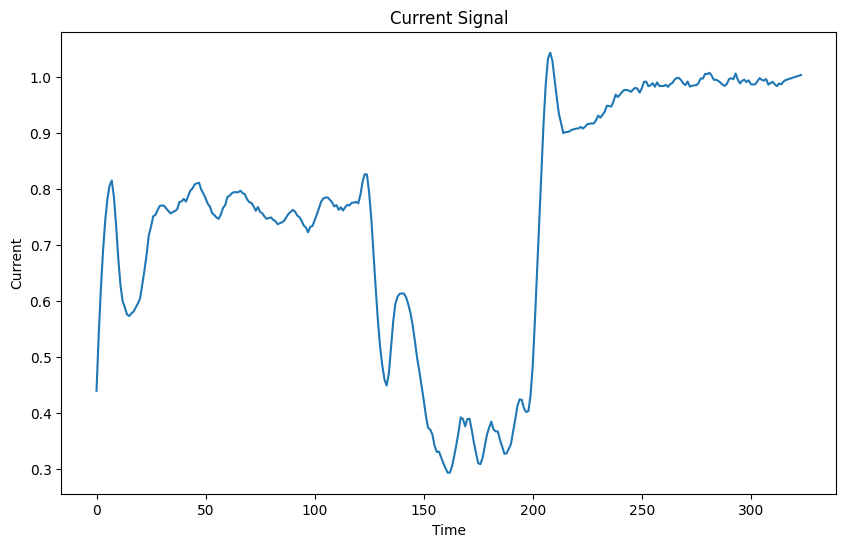

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Signal')
plt.show()

In [8]:
# Z-normalize the time series data
z_normalized_X_20kg = (X_20kg - np.mean(X_20kg, axis=1, keepdims=True)) / np.std(X_20kg, axis=1, keepdims=True)
z_normalized_X_40kg = (X_40kg - np.mean(X_40kg, axis=1, keepdims=True)) / np.std(X_40kg, axis=1, keepdims=True)
z_normalized_X_m40kg = (X_m40kg - np.mean(X_m40kg, axis=1, keepdims=True)) / np.std(X_m40kg, axis=1, keepdims=True)

In [9]:
minmax_X_20kg = 2 * (X_20kg - np.min(X_20kg, axis=1, keepdims=True)) / (np.max(X_20kg, axis=1, keepdims=True) - np.min(X_20kg, axis=1, keepdims=True)) - 1
minmax_X_40kg = 2 * (X_40kg - np.min(X_40kg, axis=1, keepdims=True)) / (np.max(X_40kg, axis=1, keepdims=True) - np.min(X_40kg, axis=1, keepdims=True)) - 1
minmax_X_m40kg = 2 * (X_m40kg - np.min(X_m40kg, axis=1, keepdims=True)) / (np.max(X_m40kg, axis=1, keepdims=True) - np.min(X_m40kg, axis=1, keepdims=True)) - 1

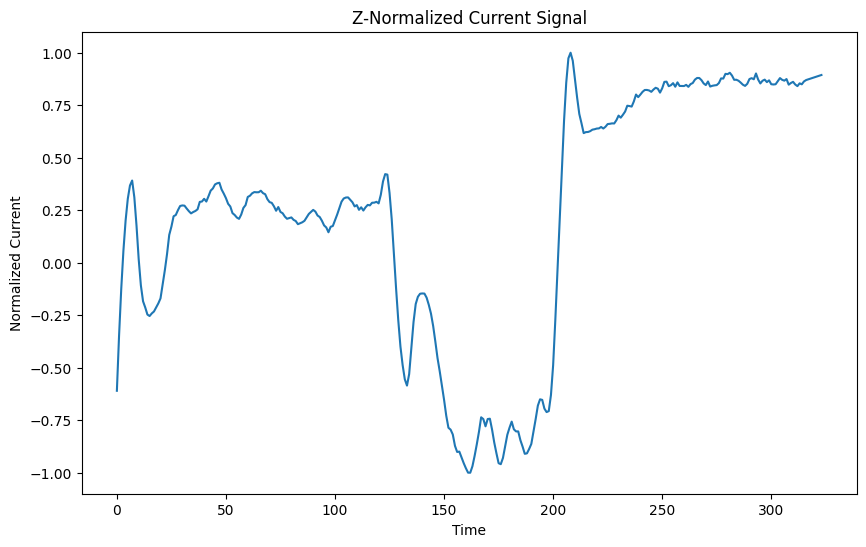

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(minmax_X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Normalized Current')
plt.title('Z-Normalized Current Signal')
plt.show()

In [11]:
lower_bound = 0.1   # Lower bound of the range (inclusive)
upper_bound = 1000  # Upper bound of the range (exclusive)
n_kernels = 1500
np.random.seed(42)  # for reproducibility
random_scales = np.random.uniform(lower_bound, upper_bound, n_kernels)
wavelet = 'morl' 

In [12]:
def trapezoidal_integral(x: List[float], y: List[float]) -> float:
    """
    Approximates the integral of a function given its data points using the Trapezoidal Rule.
    
    Parameters:
    x : array-like
        Array of x values (data points along the x-axis, uniformly spaced).
    y : array-like
        Array of y values (function values at each x).
    
    Returns:
    float
        The approximate integral value.
    """
    
    h = x[1:] - x[:-1]  # Step sizes
    integral = np.sum((h / 2) * (y[:-1] + y[1:]))  # Trapezoidal Rule
    return integral

In [13]:
coefficients, freqs = pywt.cwt(minmax_X_20kg[0], random_scales, wavelet, method='conv')
coefficients.shape

(1500, 324)

In [33]:
scaled_coefficients = 2 * (coefficients - np.min(coefficients, axis=-1, keepdims=True)) / (np.max(coefficients, axis=-1, keepdims=True) - np.min(coefficients, axis=-1, keepdims=True)) - 1

In [14]:
x_arr = np.arange(0, len(coefficients[0]))
x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
x_arr.shape

(1500, 324)

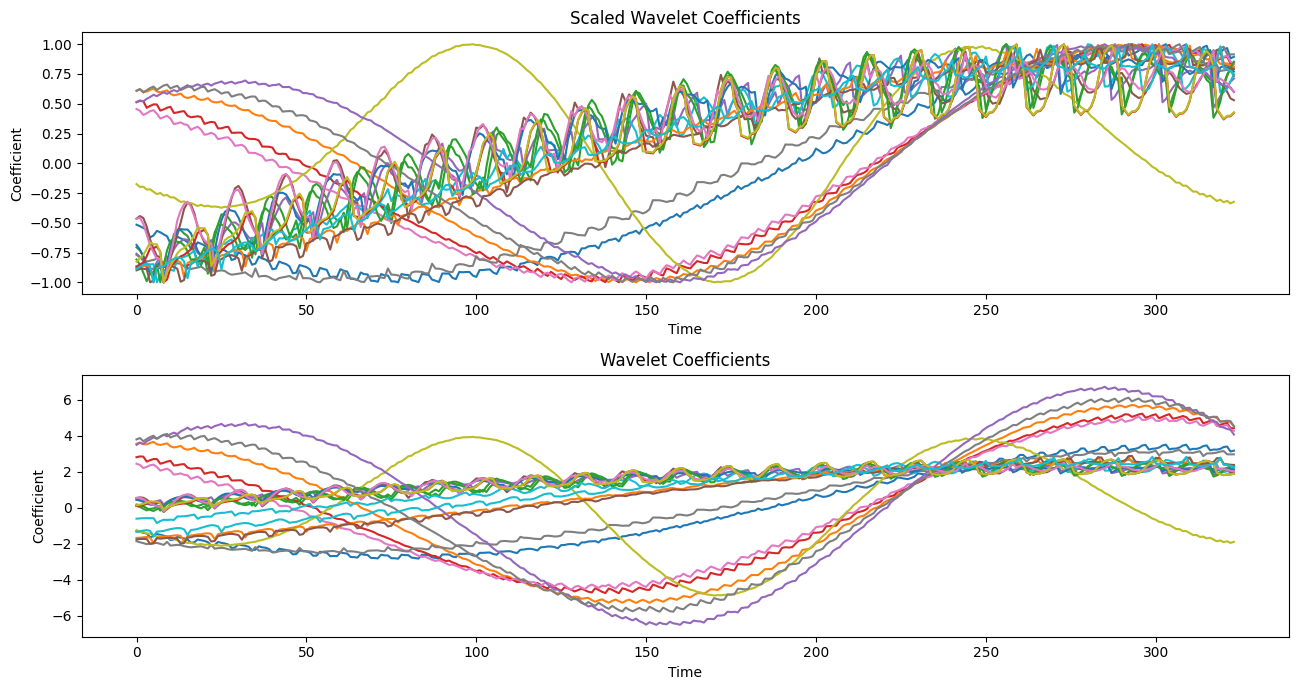

In [61]:
rand_idx = [np.random.randint(scaled_coefficients.shape[0]) for _ in range(20)]

plt.subplots(2, 1, figsize=(13, 7))
plt.subplot(2, 1, 1)
for i in range(20):
    plt.plot(x_arr[0], scaled_coefficients[rand_idx[i]])
    plt.xlabel('Time')
    plt.ylabel('Coefficient')
    plt.title('Scaled Wavelet Coefficients')

plt.subplot(2, 1, 2)
for i in range(20):
    plt.plot(x_arr[0], coefficients[rand_idx[i]])
    plt.xlabel('Time')
    plt.ylabel('Coefficient')
    plt.title('Wavelet Coefficients')

plt.tight_layout()
plt.show()

In [63]:
res = np.array([trapezoidal_integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
print(f'After integral: {res.shape}')
res

After integral: (1500,)


array([-56.41945974, 517.22445929, 429.98069389, ...,  97.10748672,
       -49.65809226, 494.75514528])

In [64]:
scaled_res = np.array([trapezoidal_integral(x_arr[i], scaled_coefficients[i]) for i in range(scaled_coefficients.shape[0])])
print(f'After integral: {scaled_res.shape}')
scaled_res

After integral: (1500,)


array([-52.31401298, 113.75407152,  68.07632401, ...,  -4.71318886,
       -49.54946785,  96.0154919 ])

In [65]:
def raven(sample, random_scales, wavelet, trapezoidal_integral):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, method='conv')
    x_arr = np.arange(0, len(coefficients[0]))
    x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
    scaled_coefficients = 2 * (coefficients - np.min(coefficients, axis=-1, keepdims=True)) / (np.max(coefficients, axis=-1, keepdims=True) - np.min(coefficients, axis=-1, keepdims=True)) - 1
    integral = np.array([trapezoidal_integral(x_arr[i], scaled_coefficients[i]) for i in range(scaled_coefficients.shape[0])])
    return integral

def raven_parallel(X, random_scales, wavelet, trapezoidal_integral, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven, X[i], random_scales, wavelet, trapezoidal_integral) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [66]:
raven_results_20kg_p = raven_parallel(minmax_X_20kg, random_scales, wavelet, trapezoidal_integral)
raven_results_20kg_np = np.array(raven_results_20kg_p)
print(raven_results_20kg_np.shape)

ridge_20 = RidgeClassifierCV()
ridge_20.fit(raven_results_20kg_np, y_20kg)

lda_20 = LDA()
lda_20.fit(raven_results_20kg_np, y_20kg)

print(f'Ridge 20kg: {ridge_20.score(raven_results_20kg_np, y_20kg)}')
print(f'LDA 20kg: {lda_20.score(raven_results_20kg_np, y_20kg)}')

100%|██████████| 374/374 [00:58<00:00,  6.44it/s]


(374, 1500)
Ridge 20kg: 1.0
LDA 20kg: 0.9893048128342246


In [67]:
raven_results_40kg_p = raven_parallel(minmax_X_40kg, random_scales, wavelet, trapezoidal_integral)
raven_results_40kg_np = np.array(raven_results_40kg_p)
print(raven_results_40kg_np.shape)

ridge_40 = RidgeClassifierCV()
ridge_40.fit(raven_results_40kg_np, y_40kg)

lda_40 = LDA()
lda_40.fit(raven_results_40kg_np, y_40kg)

print(f'Ridge 40kg: {ridge_40.score(raven_results_40kg_np, y_40kg)}')
print(f'LDA 40kg: {lda_40.score(raven_results_40kg_np, y_40kg)}')

100%|██████████| 358/358 [00:55<00:00,  6.47it/s]


(358, 1500)
Ridge 40kg: 1.0
LDA 40kg: 1.0


In [68]:
raven_results_m40kg_p = raven_parallel(minmax_X_m40kg, random_scales, wavelet, trapezoidal_integral)
raven_results_m40kg_np = np.array(raven_results_m40kg_p)
print(raven_results_m40kg_np.shape)

ridge_m40 = RidgeClassifierCV()
ridge_m40.fit(raven_results_m40kg_np, y_m40kg)

lda_m40 = LDA()
lda_m40.fit(raven_results_m40kg_np, y_m40kg)

print(f'Ridge -40kg: {ridge_m40.score(raven_results_m40kg_np, y_m40kg)}')
print(f'LDA -40kg: {lda_m40.score(raven_results_m40kg_np, y_m40kg)}')

100%|██████████| 367/367 [01:04<00:00,  5.70it/s]


(367, 1500)
Ridge -40kg: 1.0
LDA -40kg: 0.9836512261580381


In [69]:
load = '20kg'
filenames_20kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_20kg_t = [filename for sublist in filenames_20kg_t for filename in sublist]

load = '40kg'
filenames_40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_40kg_t = [filename for sublist in filenames_40kg_t for filename in sublist]

load = '-40kg'
filenames_m40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_m40kg_t = [filename for sublist in filenames_m40kg_t for filename in sublist]

In [70]:
X_20kg_t, y_20kg_t = get_X_y(filenames_20kg_t, load='20kg', is_train=False)
X_40kg_t, y_40kg_t = get_X_y(filenames_40kg_t, load='40kg', is_train=False)
X_m40kg_t, y_m40kg_t = get_X_y(filenames_m40kg_t, load='-40kg', is_train=False)

In [71]:
# z_normalized_X_20kg_t = (X_20kg_t - np.mean(X_20kg_t, axis=1, keepdims=True)) / np.std(X_20kg_t, axis=1, keepdims=True) 
# z_normalized_X_40kg_t = (X_40kg_t - np.mean(X_40kg_t, axis=1, keepdims=True)) / np.std(X_40kg_t, axis=1, keepdims=True)
# z_normalized_X_m40kg_t = (X_m40kg_t - np.mean(X_m40kg_t, axis=1, keepdims=True)) / np.std(X_m40kg_t, axis=1, keepdims=True)

In [72]:
minmax_X_20kg_t = 2 * (X_20kg_t - np.min(X_20kg_t, axis=1, keepdims=True)) / (np.max(X_20kg_t, axis=1, keepdims=True) - np.min(X_20kg_t, axis=1, keepdims=True)) - 1
minmax_X_40kg_t = 2 * (X_40kg_t - np.min(X_40kg_t, axis=1, keepdims=True)) / (np.max(X_40kg_t, axis=1, keepdims=True) - np.min(X_40kg_t, axis=1, keepdims=True)) - 1
minmax_X_m40kg_t = 2 * (X_m40kg_t - np.min(X_m40kg_t, axis=1, keepdims=True)) / (np.max(X_m40kg_t, axis=1, keepdims=True) - np.min(X_m40kg_t, axis=1, keepdims=True)) - 1

In [73]:
raven_results_20kg_t = raven_parallel(minmax_X_20kg_t, random_scales, wavelet, trapezoidal_integral)
raven_results_20kg_t_np = np.array(raven_results_20kg_t)
print(f'Ridge 20kg test: {ridge_20.score(raven_results_20kg_t_np, y_20kg_t)}')
print(f'LDA 20kg test: {lda_20.score(raven_results_20kg_t_np, y_20kg_t)}')

  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 130/130 [00:22<00:00,  5.89it/s]

Ridge 20kg test: 0.5846153846153846
LDA 20kg test: 0.6307692307692307


In [74]:
raven_results_40kg_t = raven_parallel(minmax_X_40kg_t, random_scales, wavelet, trapezoidal_integral)
raven_results_40kg_t_np = np.array(raven_results_40kg_t)
print(f'Ridge 40kg test:{ridge_40.score(raven_results_40kg_t_np, y_40kg_t)}')
print(f'LDA 40kg test: {lda_40.score(raven_results_40kg_t_np, y_40kg_t)}')

100%|██████████| 129/129 [00:21<00:00,  6.12it/s]

Ridge 40kg test:0.5503875968992248
LDA 40kg test: 0.6434108527131783


In [75]:
raven_result_m40kg_t = raven_parallel(minmax_X_m40kg_t, random_scales, wavelet, trapezoidal_integral)
raven_result_m40kg_t_np = np.array(raven_result_m40kg_t)
print(f'Ridge -40kg test: {ridge_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')
print(f'LDA -40kg test: {lda_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')

100%|██████████| 130/130 [00:21<00:00,  6.15it/s]

Ridge -40kg test: 0.4846153846153846
LDA -40kg test: 0.6461538461538462


## Use ROCKET for Comparison

In [29]:
from pyts.transformation import ROCKET

rocket = ROCKET(random_state=0)

rocket.fit(X_20kg)

rocket_results_20kg = rocket.transform(X_20kg)
rocket_results_20kg_t = rocket.transform(X_20kg_t)
rocket_20 = RidgeClassifierCV()
lda_20_ = LDA()
rocket_20.fit(rocket_results_20kg, y_20kg)
lda_20_.fit(rocket_results_20kg, y_20kg)
print(f'20kg train Ridge: {rocket_20.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test Ridge: {rocket_20.score(rocket_results_20kg_t, y_20kg_t)}')
print(f'20kg train LDA: {lda_20_.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test LDA: {lda_20_.score(rocket_results_20kg_t, y_20kg_t)}')

20kg train Ridge: 0.9973262032085561
20kg test Ridge: 0.7307692307692307
20kg train LDA: 0.21390374331550802
20kg test LDA: 0.2076923076923077


In [30]:
rocket.fit(X_40kg)

rocket_results_40kg = rocket.transform(X_40kg)
rocket_results_40kg_t = rocket.transform(X_40kg_t)
rocket_40 = RidgeClassifierCV()
lda_40_ = LDA()
rocket_40.fit(rocket_results_40kg, y_40kg)
lda_40_.fit(rocket_results_40kg, y_40kg)
print(f'40kg train: {rocket_40.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test: {rocket_40.score(rocket_results_40kg_t, y_40kg_t)}')
print(f'40kg train LDA: {lda_40_.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test LDA: {lda_40_.score(rocket_results_40kg_t, y_40kg_t)}')

40kg train: 1.0
40kg test: 0.7209302325581395
40kg train LDA: 0.13966480446927373
40kg test LDA: 0.13178294573643412


In [31]:
rocket.fit(X_m40kg)

rocket_results_m40kg = rocket.transform(X_m40kg)
rocket_results_m40kg_t = rocket.transform(X_m40kg_t)
rocket_m40 = RidgeClassifierCV()
lda_m40_ = LDA()
rocket_m40.fit(rocket_results_m40kg, y_m40kg)
lda_m40_.fit(rocket_results_m40kg, y_m40kg)
print(f'm40kg train: {rocket_m40.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test: {rocket_m40.score(rocket_results_m40kg_t, y_m40kg_t)}')
print(f'm40kg train LDA: {lda_m40_.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test LDA: {lda_m40_.score(rocket_results_m40kg_t, y_m40kg_t)}')

m40kg train: 1.0
-40kg test: 0.7615384615384615
m40kg train LDA: 0.20708446866485014
-40kg test LDA: 0.18461538461538463
